# 멋진 작사가 만들기

**학습 목표**

인공지능이 문장을 이해하는 방식과 작문을 가르치는 법을 배우기

시퀸스 이해 해보기

인공지능 중 하나인 순환신경망(RNN)을 활용할 수 있다

멋진 인공지능 작사가 만들어보기

**Step 1. 데이터 다운로드**

Cloud shell에서 아래 명령어를 입력해 연결할 수 있다

$ mkdir -p ~/aiffel/lyricist/models

$ ln -s ~/data ~/aiffel/lyricist/data

**Step 2. 데이터 읽어오기**

In [7]:
import glob # glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이
import os, re
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) # glob 를 활용하여 모든 txt 파일을 읽어온다

raw_corpus = [] # raw_corpus 리스트에 문장 단위로 저장

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # 읽기 모드로 열고 라인단위(splitlines())로 끊기
        raw_corpus.extend(raw) # raw_corpus에 raw데이터를 추가한다

print("데이터 크기:", len(raw_corpus)) # 데이터 크기 확인
print("Examples:\n", raw_corpus[:4]) # 앞에서 부터 4라인 화면으로 확인 해보기

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this']


**Step 3. 데이터 정제**

In [8]:
def preprocess_sentence(sentence): # 정규표현식을 이용한 필터링
    sentence = sentence.lower().strip() # 1 소문자로 바꾸고, 양쪽 공백을 지웁니다
		# import한 re모듈에서 sub불러옴
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꾼다
    # 앞에 붙은 r'은 raw string : 날것 그대로 문자표현
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
    # ^ : 여집합 반대된다는 뜻
    sentence = sentence.strip() # 5 다시 양쪽 공백을 지운다
    sentence = '<start> ' + sentence + ' <end>' # 6문장 시작에는 <start>, 끝에는 <end>를 추가한다
    return sentence

In [9]:
#이 정제 함수를 활용해서 아래와 같이 정제 데이터를 구축합니다!
corpus = [] # 여기에 정제된 문장을 모을겁니다

for sentence in raw_corpus: # 정규표현식을 이용한 corpus 생성
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    #if sentence[-1] == ":": continue
    
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue # 15개를 넘어가는 학습데이터 제외
        
    corpus.append(preprocessed_sentence)

maxlen을 지정했는데도 데이터가 12만개로 줄지 않아서 for sentence 반복문 안에서 if len(sentence.split()) > 15: continue를 지정 해봤지만 여전히 14만개 이상으로 나와서 다른곳에 지정하면 될까 싶어서 위치를 찾아봤는데 정제를 하고난 후로 if len(preprocessed_sentence.split()) > 15: continue로 지정했더니 노드값과 일치하지는 않았지만 매우 비슷한값으로 데이터가 측정되었다 

**Step 4. 평가 데이터셋 분리**

텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공 해주는데 
tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전을 만들어주고, 
데이터를 숫자로 변환까지 해줍니다 

이 과정을 벡터화 라고 하며 숫자로 변환된 데이터를 텐서로 칭한다고 한다

In [10]:
def tokenize(corpus): # tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
    # 120000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # padding에 post를 사용하면 문장 뒤에 패딩을 붙여 길이를 맞추고, pre를 사용하면 문장 앞에 패딩을 붙여 길이를 맞춤
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc45873ff10>


글자 길이를 15자 이내로 제한해야해서 구글링하다가 pad_sequences () 함수는 관찰 된 시퀀스보다 긴 선호 길이로 시퀀스를 채우는 데 사용
pad_sequences () 함수에 maxlen 인수로 원하는 길이로 지정하여 수행할수 있다고 해서 maxlen을 지정 해봤으나 큰 효과를 보지 못했음

In [11]:
# # 단어 사전 구축된것 확인해보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


모든 행이 2번으로 시작하는 이유는 인덱스 2번이 <start>였기 때문이다

In [10]:
# 생성된 텐서를 소스와 타겟으로 분리하여 모델 학습해보자

# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다

src_input = tensor[:, :-1]  # 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.

tgt_input = tensor[:, 1:] # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0]) # 소스는 2(<start>)로 시작에서 3(<end>)으로 끝난후 0(<pad>)으로 채워져있음

print(tgt_input[0]) # # 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한칸 시프트하고 3(<end>) 끝난후 0(<pad>)으로 채워져있음


# 데이터셋 객체를 생성하자

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다

# 텐서플로우를 활용할 경우에는 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용한다고 한다
# tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하므로
# 사용법을 알아두자

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
# tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

dataset = dataset.shuffle(BUFFER_SIZE) # # shuffle() 섞어줌
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # batch() 데이터 배치의 크기를 정함

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [11]:
from sklearn.model_selection import train_test_split

# train_test_split 사용하여 데이터를 분리하기
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, shuffle=True, random_state=34)

In [12]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Valid", enc_val.shape)
print("Target Valid", dec_val.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)
Source Valid (31246, 14)
Target Valid (31246, 14)


**Step 5. 인공지능 만들기**

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 # embedding_size는 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기
hidden_size = 1024 # hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인지를 정함
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [14]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample) 

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.99584931e-04, -9.72676062e-05, -5.16301479e-05, ...,
          1.04030449e-04, -2.05451201e-04,  9.32326948e-05],
        [-4.30641434e-04,  3.84882878e-05,  1.50518108e-05, ...,
          1.31625900e-04, -3.75612173e-04,  2.09432503e-04],
        [-7.29555322e-04,  3.26782319e-04,  2.21711496e-04, ...,
          1.29383596e-04, -5.99724881e-04,  2.64310132e-04],
        ...,
        [-2.00818852e-03, -2.33274954e-03, -2.48397584e-04, ...,
          8.17987486e-04, -1.51411619e-03, -3.73317947e-04],
        [-2.12906557e-03, -2.56541534e-03, -3.89197696e-04, ...,
          6.75767718e-04, -1.63541920e-03, -4.21561766e-04],
        [-2.25323439e-03, -2.72221467e-03, -5.04060416e-04, ...,
          5.09675825e-04, -1.75358495e-03, -4.49031853e-04]],

       [[-1.99584931e-04, -9.72676062e-05, -5.16301479e-05, ...,
          1.04030449e-04, -2.05451201e-04,  9.32326948e-05],
        [-1.37246840e-04, -1.17793083e-04, -1

In [15]:
# 모델 구조 확인하기
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델 학습 시키기
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# 오답률이 감소하고 있으면 잘 진행되고 있다는거라고 한다
model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10, validation_data=(enc_val, dec_val))

Epoch 1/10
610/610 [==============================] - 110s 172ms/step - loss: 3.4210 - val_loss: 3.0451
Epoch 2/10
610/610 [==============================] - 111s 182ms/step - loss: 2.9598 - val_loss: 2.8266
Epoch 3/10
610/610 [==============================] - 111s 182ms/step - loss: 2.7890 - val_loss: 2.6792
Epoch 4/10
610/610 [==============================] - 111s 182ms/step - loss: 2.6613 - val_loss: 2.5605
Epoch 5/10
610/610 [==============================] - 111s 182ms/step - loss: 2.5524 - val_loss: 2.4527
Epoch 6/10
610/610 [==============================] - 111s 182ms/step - loss: 2.4546 - val_loss: 2.3600
Epoch 7/10
610/610 [==============================] - 111s 182ms/step - loss: 2.3645 - val_loss: 2.2691
Epoch 8/10
610/610 [==============================] - 111s 182ms/step - loss: 2.2804 - val_loss: 2.1896
Epoch 9/10
610/610 [==============================] - 111s 182ms/step - loss: 2.2026 - val_loss: 2.1143
Epoch 10/10
610/610 [==============================] - 111s 182m

**잘 만들어졌는지 평가하기**

In [17]:
# generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다. 
    while True:
        # 1 입력받은 문장의 텐서를 입력합니다
        predict = model(test_tensor) 
        # 2 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 2에서 예측된 word index를 문장 뒤에 붙입니다
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " " 
    return generated

In [18]:
generate_text(model, tokenizer, init_sentence="<start> next level", max_len=20)

'<start> next level , you re my symphony <end> '

**회고**

프로젝트 만드는 순서대로 쭉쭉 따라했는데 노드에 나와있는 만큼에 데이터수가 안나왔어요. 그래서 maxlen값을 적용하면 된다는 것을 찾아서 해봤으나 크게 달라지는게 없었어요. 그래서 새로 if문을 만들어서 적용을 했더니 14만개 정도로 데이터가 적용되었어요. 하지만 12만개 되지 않았기 때문에 만들 if문을 여러군데로 옮겨 보았고 정제한후 if문을 적용하는 것으로 생각해 preprocessed_sentence로 적용해보았더니 비슷하게 맞아졌어요. 데이터수를 해결하고 난뒤 학습을 돌렸는데 val_loss가 없어서 구하는법을 찾아보았는데 구글링에서 시키는대로 해봤는데 잘되지 않았어요. 그래서 슨배님들꺼 보면서 적용해봤는데 또 안되길래 뭐가 문제 일까 하다가 그냥 돌려봤는데 val_loss값이 갑자기 나왔어요. 그래서 올려보니 새로 줬었던 validation_data=(enc_val, dec_val)값이 먹혔고 val_loss값이 2.2이하로 떨어졌어요. 그런데 다른분들은 다 안된다고 하길래 내가 잘못한건가 생각이 들어서 더 만져 보다가 ex6에서 나온 post값을 pre로 바꾸면 10%정도 더 좋아진다 길래 적용 해봤는데 loss값이 오히려 오히려 올라갔어요. 어쨌든 루브릭에서 얘기한 값은 맞춘거 같아서 마무리 하는데 잘한건지 못한건지 확실하게 알수는 없는것 같아요.

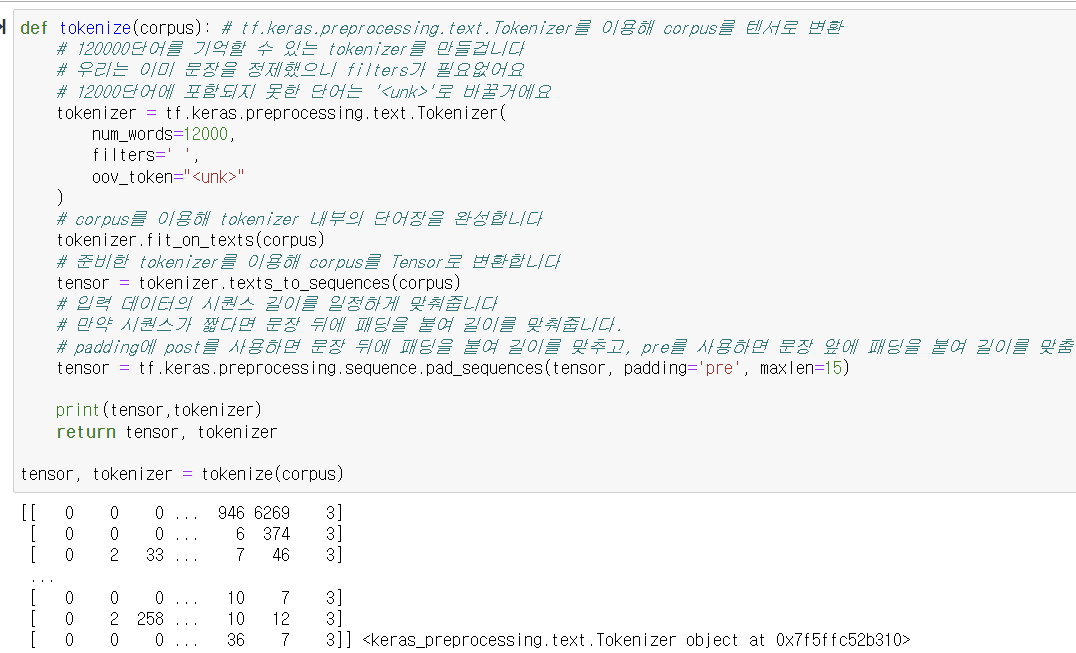

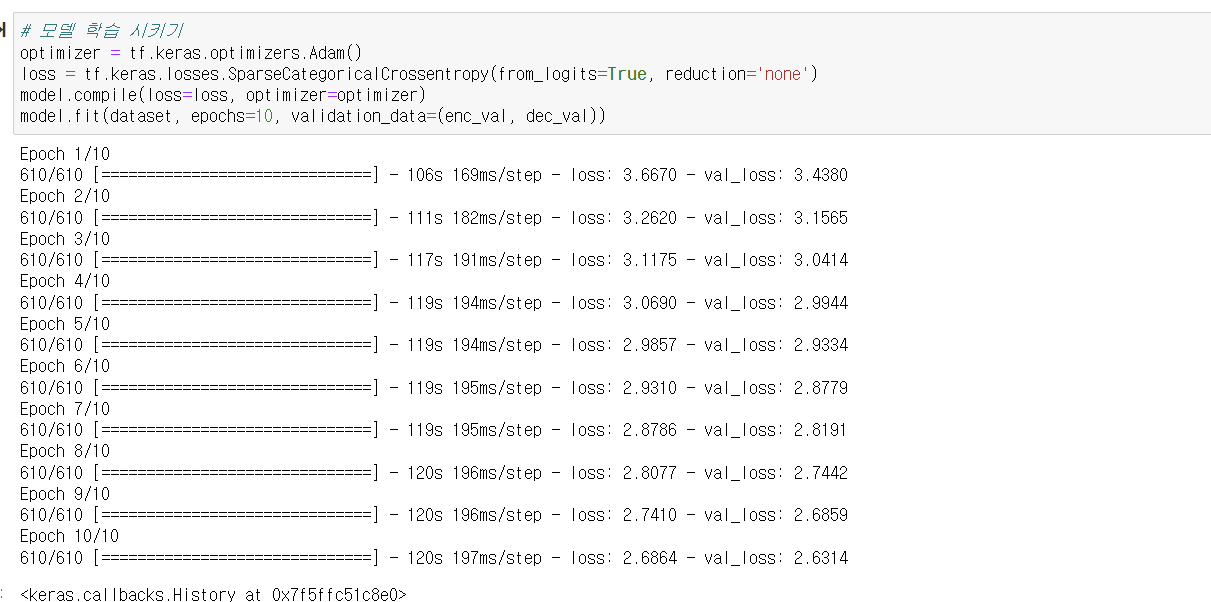